<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/bootcamp/tutorials/quickstart/vector_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>   <a href="https://github.com/milvus-io/bootcamp/blob/master/bootcamp/tutorials/quickstart/vector_visualization.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View%20on%20GitHub-555555?style=flat&logo=github&logoColor=white" alt="GitHub Repository"/>

# Vector Visualization
In this example, we will show how to visualize the embeddings(vectors) in Milvus using [t-SNE](https://www.wikiwand.com/en/articles/T-distributed_stochastic_neighbor_embedding).

Dimensionality reduction techniques, such as t-SNE, are invaluable for visualizing complex, high-dimensional data in a 2D or 3D space while preserving the local structure. This enables pattern recognition, enhances understanding of feature relationships, and facilitates the interpretation of machine learning model outcomes. Additionally, it aids in algorithm evaluation by visually comparing clustering results, simplifies data presentation to non-specialist audiences, and can reduce computational costs by working with lower-dimensional representations. Through these applications, t-SNE not only helps in gaining deeper insights into datasets but also supports more informed decision-making processes.

## Preparation

### Dependencies and Environment

In [ ]:
! pip install --upgrade pymilvus openai requests tqdm matplotlib seaborn

We will use OpenAI's embedding model in this example. You should prepare the api key OPENAI_API_KEY as an environment variable.

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-***********"

## Prepare the data

We use the FAQ pages from the Milvus [Documentation 2.4.x](https://github.com/milvus-io/milvus-docs/releases/download/v2.4.6-preview/milvus_docs_2.4.x_en.zip) as the private knowledge in our RAG, which is a good data source for a simple RAG pipeline.

Download the zip file and extract documents to the folder `milvus_docs`.

In [ ]:
! wget https://github.com/milvus-io/milvus-docs/releases/download/v2.4.6-preview/milvus_docs_2.4.x_en.zip
! unzip -q milvus_docs_2.4.x_en.zip -d milvus_docs

We load all markdown files from the folder `milvus_docs/en/faq`. For each document, we just simply use "# " to separate the content in the file, which can roughly separate the content of each main part of the markdown file.

In [1]:
from glob import glob

text_lines = []

for file_path in glob("milvus_docs/en/faq/*.md", recursive=True):
    with open(file_path, "r") as file:
        file_text = file.read()

    text_lines += file_text.split("# ")

## Prepare the Embedding Model

We initialize the OpenAI client to prepare the embedding model.

In [2]:
from openai import OpenAI

openai_client = OpenAI()

Define a function to generate text embeddings using OpenAI client. We use the [text-embedding-3-large](https://platform.openai.com/docs/guides/embeddings) model as an example.

In [31]:
def emb_text(text):
    return (
        openai_client.embeddings.create(input=text, model="text-embedding-3-large")
        .data[0]
        .embedding
    )

Generate a test embedding and print its dimension and first few elements.

In [32]:
test_embedding = emb_text("This is a test")
embedding_dim = len(test_embedding)
print(embedding_dim)
print(test_embedding[:10])

3072
[-0.015370666049420834, 0.00234124343842268, -0.01011690590530634, 0.044725317507982254, -0.017235849052667618, -0.02880779094994068, -0.026678944006562233, 0.06816216558218002, -0.011376636102795601, 0.021659553050994873]


## Load data into Milvus

### Create the Collection

In [33]:
from pymilvus import MilvusClient

milvus_client = MilvusClient(uri="./milvus_demo.db")

collection_name = "my_rag_collection"

> As for the argument of `MilvusClient`:
>
> - Setting the `uri` as a local file, e.g.`./milvus.db`, is the most convenient method, as it automatically utilizes [Milvus Lite](https://milvus.io/docs/milvus_lite.md) to store all data in this file.
> - If you have large scale of data, you can set up a more performant Milvus server on [docker or kubernetes](https://milvus.io/docs/quickstart.md). In this setup, please use the server uri, e.g.`http://localhost:19530`, as your `uri`.
> - If you want to use [Zilliz Cloud](https://zilliz.com/cloud), the fully managed cloud service for Milvus, adjust the `uri` and `token`, which correspond to the [Public Endpoint and Api key](https://docs.zilliz.com/docs/on-zilliz-cloud-console#free-cluster-details) in Zilliz Cloud.

Check if the collection already exists and drop it if it does.

In [34]:
if milvus_client.has_collection(collection_name):
    milvus_client.drop_collection(collection_name)

Create a new collection with specified parameters.

If we don’t specify any field information, Milvus will automatically create a default `id` field for primary key, and a `vector` field to store the vector data. A reserved JSON field is used to store non-schema-defined fields and their values.

In [35]:
milvus_client.create_collection(
    collection_name=collection_name,
    dimension=embedding_dim,
    metric_type="IP",  # Inner product distance
    consistency_level="Strong",  # Strong consistency level
)

## Insert data

Iterate through the text lines, create embeddings, and then insert the data into Milvus.

Here is a new field `text`, which is a non-defined field in the collection schema. It will be automatically added to the reserved JSON dynamic field, which can be treated as a normal field at a high level.

In [36]:
from tqdm import tqdm

data = []

for i, line in enumerate(tqdm(text_lines, desc="Creating embeddings")):
    data.append({"id": i, "vector": emb_text(line), "text": line})

milvus_client.insert(collection_name=collection_name, data=data)

Creating embeddings: 100%|██████████| 72/72 [00:20<00:00,  3.60it/s]


{'insert_count': 72, 'ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], 'cost': 0}

## Visualizing Embeddings in Vector Search

In this section, we perform a milvus search and then visualize the query vector and the retrieved vector together in reduced dimension.

### Retrieve Data for a Query

Let's prepare a question for the search.

In [37]:
# Modify the question to test it with your own query!

question = "How is data stored in Milvus?"

Search for the question in the collection and retrieve the semantic top-10 matches.

In [38]:
search_res = milvus_client.search(
    collection_name=collection_name,
    data=[
        emb_text(question)
    ],  # Use the `emb_text` function to convert the question to an embedding vector
    limit=10,  # Return top 10 results
    search_params={"metric_type": "IP", "params": {}},  # Inner product distance
    output_fields=["text"],  # Return the text field
)

Let’s take a look at the search results of the query

In [44]:
import json

retrieved_lines_with_distances = [
    (res["entity"]["text"], res["distance"]) for res in search_res[0]
]
print(json.dumps(retrieved_lines_with_distances, indent=4))

[
    [
        " Where does Milvus store data?\n\nMilvus deals with two types of data, inserted data and metadata. \n\nInserted data, including vector data, scalar data, and collection-specific schema, are stored in persistent storage as incremental log. Milvus supports multiple object storage backends, including [MinIO](https://min.io/), [AWS S3](https://aws.amazon.com/s3/?nc1=h_ls), [Google Cloud Storage](https://cloud.google.com/storage?hl=en#object-storage-for-companies-of-all-sizes) (GCS), [Azure Blob Storage](https://azure.microsoft.com/en-us/products/storage/blobs), [Alibaba Cloud OSS](https://www.alibabacloud.com/product/object-storage-service), and [Tencent Cloud Object Storage](https://www.tencentcloud.com/products/cos) (COS).\n\nMetadata are generated within Milvus. Each Milvus module has its own metadata that are stored in etcd.\n\n###",
        0.7675539255142212
    ],
    [
        "How does Milvus handle vector data types and precision?\n\nMilvus supports Binary, Float

### Dimensionality reduction to 2-d by t-SNE

Let's reduce the dimension of the embeddings to 2-d by t-SNE. We will use the `sklearn` library to perform the t-SNE transformation.

In [45]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

data.append({"id": len(data), "vector": emb_text(question), "text": question})
embeddings = []
for gp in data:
    embeddings.append(gp["vector"])

X = np.array(embeddings, dtype=np.float32)
tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne

,TSNE1,TSNE2
0,-3.877362,0.866726
1,-5.923084,0.671701
2,-0.645954,0.240083
3,0.444582,1.222875
4,6.503896,-4.984684
...,...,...
69,6.354055,1.264959
70,6.055961,1.266211
71,-1.516003,1.328765
72,3.971772,-0.681780


### Visualizing Milvus search results on a 2d plane

We will plot the query vector in green, the retrieved vectors in red, and the remaining vectors in blue.

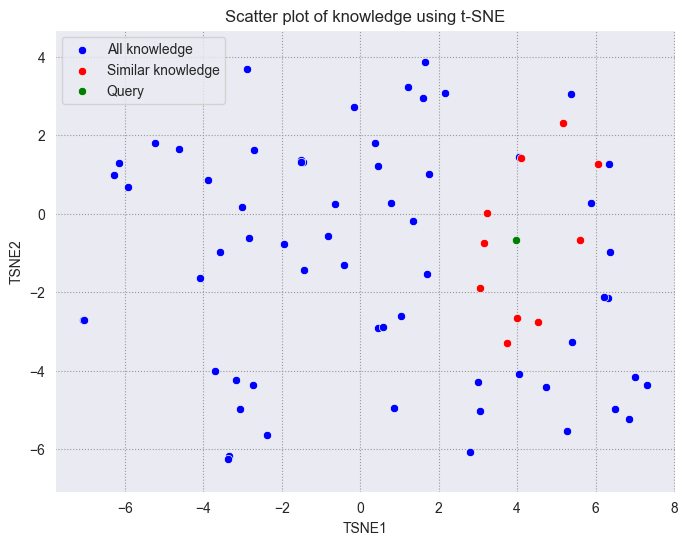

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract similar ids from search results
similar_ids = [gp["id"] for gp in search_res[0]]

df_norm = df_tsne[:-1]

df_query = pd.DataFrame(df_tsne.iloc[-1]).T

# Filter points based on similar ids
similar_points = df_tsne[df_tsne.index.isin(similar_ids)]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))  # Set figsize

# Set the style of the plot
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Plot all points in blue
sns.scatterplot(
    data=df_tsne, x="TSNE1", y="TSNE2", color="blue", label="All knowledge", ax=ax
)

# Overlay similar points in red
sns.scatterplot(
    data=similar_points,
    x="TSNE1",
    y="TSNE2",
    color="red",
    label="Similar knowledge",
    ax=ax,
)

sns.scatterplot(
    data=df_query, x="TSNE1", y="TSNE2", color="green", label="Query", ax=ax
)

# Set plot titles and labels
plt.title("Scatter plot of knowledge using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")

# Set axis to be equal
plt.axis("equal")

# Display the legend
plt.legend()

# Show the plot
plt.show()

As we can see, the query vector is close to the retrieved vectors. Although the retrieved vectors are not within a standard circle with a fixed radius centered on the query, we can see that they are still very close to the query vector on the 2D plane.

Using dimensionality reduction techniques can facilitate the understanding of vectors and troubleshooting. Hope you can get a better understanding of vectors through this tutorial.